## Loan Eligibility Prediction Using Machine Learning

In [ ]:
#%reset

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Statistical Analysis
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

# Utilities
from sklearn.utils import Bunch

import warnings
warnings.filterwarnings('ignore')

### 1. Data Understanding

In [ ]:
# Read the dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Github/train.csv")

In [ ]:
# Display the general description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [ ]:
# Display the first 5 rows
df.head(5)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [ ]:
# Define variable for categorical columns
cat_col=list(df.select_dtypes(include='object').columns)

In [ ]:
df.select_dtypes(include='object')

,Batch Enrolled,Grade,Sub Grade,Employment Duration,Verification Status,Payment Plan,Loan Title,Initial List Status,Application Type
0,BAT2522922,B,C4,MORTGAGE,Not Verified,n,Debt Consolidation,w,INDIVIDUAL
1,BAT1586599,C,D3,RENT,Source Verified,n,Debt consolidation,f,INDIVIDUAL
2,BAT2136391,F,D4,MORTGAGE,Source Verified,n,Debt Consolidation,w,INDIVIDUAL
3,BAT2428731,C,C3,MORTGAGE,Source Verified,n,Debt consolidation,w,INDIVIDUAL
4,BAT5341619,C,D4,MORTGAGE,Source Verified,n,Credit card refinancing,w,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...
67458,BAT3193689,C,A4,MORTGAGE,Verified,n,Credit card refinancing,w,INDIVIDUAL
67459,BAT1780517,C,B3,RENT,Source Verified,n,Credit card refinancing,w,INDIVIDUAL
67460,BAT1761981,A,F3,MORTGAGE,Verified,n,Lending loan,w,INDIVIDUAL
67461,BAT2333412,D,E3,OWN,Not Verified,n,Debt consolidation,f,INDIVIDUAL


In [ ]:
cat_col

['Batch Enrolled',
 'Grade',
 'Sub Grade',
 'Employment Duration',
 'Verification Status',
 'Payment Plan',
 'Loan Title',
 'Initial List Status',
 'Application Type']

In [ ]:
# Missing Values Analysis
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
                              Missing Values  Percentage
ID                                         0         0.0
Collection Recovery Fee                    0         0.0
Revolving Utilities                        0         0.0
Total Accounts                             0         0.0
Initial List Status                        0         0.0
Total Received Interest                    0         0.0
Total Received Late Fee                    0         0.0
Recoveries                                 0         0.0
Collection 12 months Medical               0         0.0
Public Record                              0         0.0
Application Type                           0         0.0
Last week Pay                              0         0.0
Accounts Delinquent                        0         0.0
Total Collection Amount                    0         0.0
Total Current Balance                      0         0.0
Total Revolving Credit Limit               0         0.0
Revolvi

In [ ]:
# Unique Value Analysis for Categorical Columns
categorical_columns = df.select_dtypes(include='object').columns
unique_counts = {col: df[col].nunique() for col in categorical_columns}
print("Unique Value Counts for Categorical Columns:")
print(pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Values']))

Unique Value Counts for Categorical Columns:
                Column  Unique Values
0       Batch Enrolled             41
1                Grade              7
2            Sub Grade             35
3  Employment Duration              3
4  Verification Status              3
5         Payment Plan              1
6           Loan Title            109
7  Initial List Status              2
8     Application Type              2


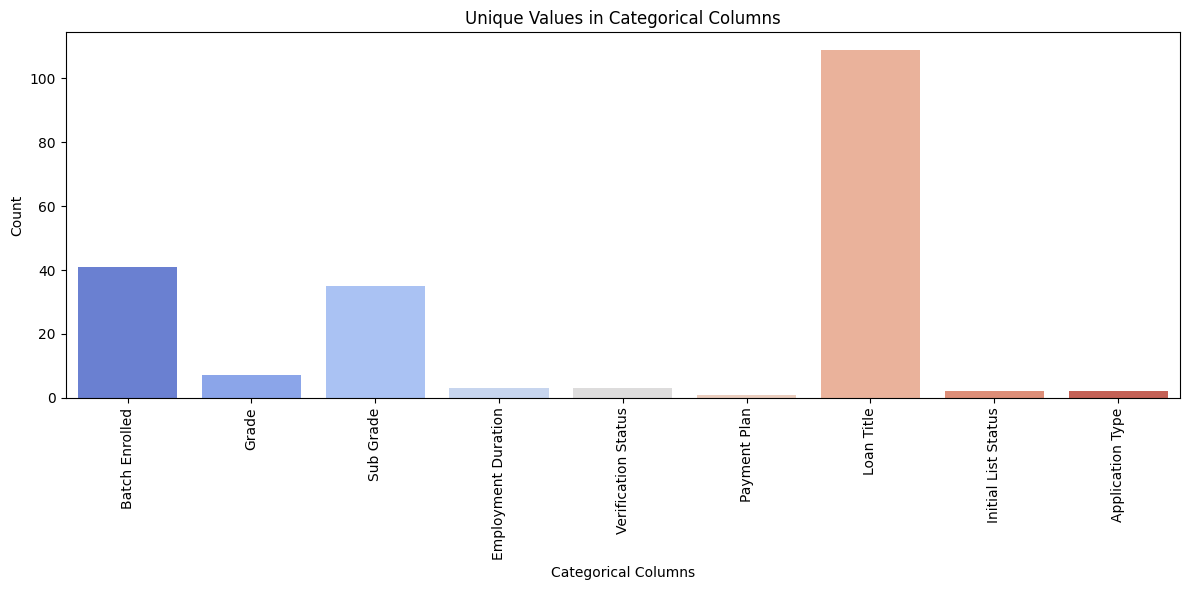

In [ ]:
# Visualize Unique Counts
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(x=list(unique_counts.keys()), y=list(unique_counts.values()), palette="coolwarm")
plt.title('Unique Values in Categorical Columns')
plt.ylabel('Count')
plt.xlabel('Categorical Columns')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Pairplot for Numerical Features
numerical_columns = df.select_dtypes(include=np.number).columns
if len(numerical_columns) > 1:
    sns.pairplot(df[numerical_columns])
    plt.suptitle('Pairplot of Numerical Features', y=1.02)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Skewness of Numerical Features:
Total Collection Amount         12.910972
Collection Recovery Fee         11.102131
Recoveries                       7.371787
Collection 12 months Medical     6.631051
Public Record                    6.236185
Total Received Late Fee          5.084511
Delinquency - two years          4.635021
Inquires - six months            3.711972
Revolving Balance                2.951135
Loan Status                      2.812817
Total Received Interest          2.135243
Home Ownership                   2.130488
Total Revolving Credit Limit     1.977150
Total Current Balance            1.511578
Open Account                     1.465107
Funded Amount Investor           0.990139
Total Accounts                   0.734122
Funded Amount                    0.672633
Interest Rate                    0.563383
ID                               0.556577
Loan Amount                      0.288083
Last week Pay                    0.261989
Debit to Income                  0.080967
Ac

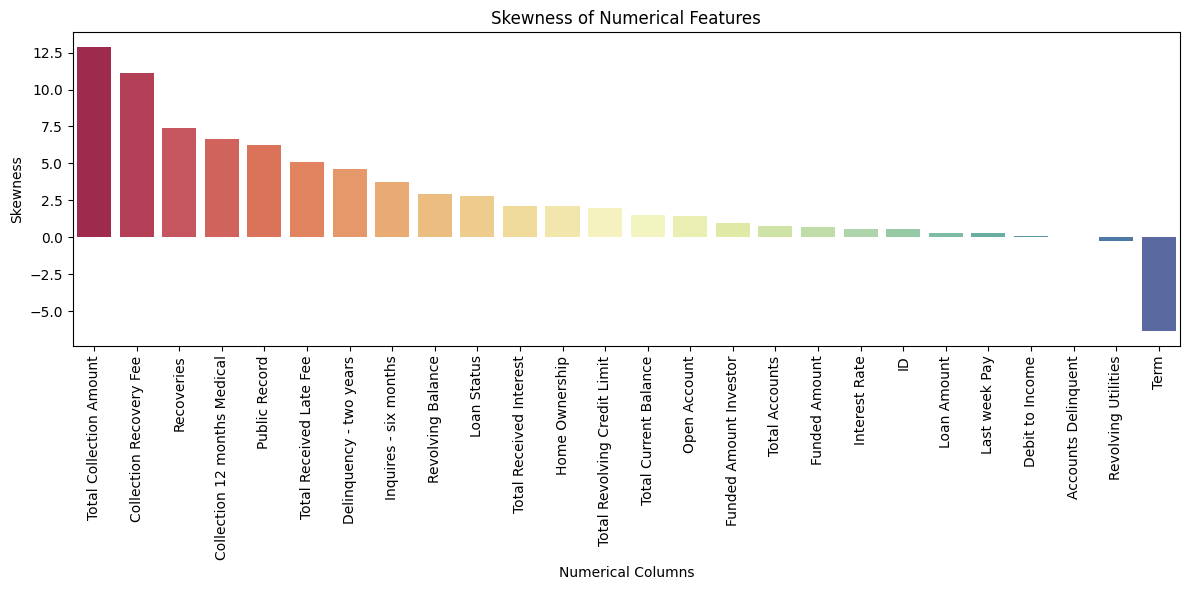

In [ ]:
# Skewness Analysis
skewness = df[numerical_columns].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness of Numerical Features:")
print(skewness)

# Visualize Skewness
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(x=skewness.index, y=skewness.values, palette="Spectral")
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.xlabel('Numerical Columns')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
temp=pd.DataFrame(columns=['Feature', 'cardinality'])

In [ ]:
temp

,Feature,cardinality


In [ ]:
# Read number of unique values for each categorical column
for i  in range(len(cat_col)):
    temp.loc[i,'Feature']=cat_col[i]
    temp.loc[i,'cardinality']=df[cat_col[i]].nunique()

temp.sort_values(by='cardinality',ascending=False).style.background_gradient(cmap='jet')

,Feature,cardinality
6,Loan Title,109
0,Batch Enrolled,41
2,Sub Grade,35
1,Grade,7
3,Employment Duration,3
4,Verification Status,3
7,Initial List Status,2
8,Application Type,2
5,Payment Plan,1


In [ ]:
# Drop unnecessary columns (high cardinality or low predictive power)
df_encode=df.drop(['Loan Title',"Accounts Delinquent",'Batch Enrolled','Sub Grade','Payment Plan','ID'],axis=1)

In [ ]:
# Check for duplicate values
duplicate_rows = df_encode[df_encode.duplicated()]

In [ ]:
duplicate_rows

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status


In [ ]:
# If duplicates are found, remove them
if not duplicate_rows.empty:
    df_encode = df_encode.drop_duplicates()

In [ ]:
# Check for constant columns (columns with a single unique value)
constant_columns = [col for col in df_encode.columns if df_encode[col].nunique() == 1]

In [ ]:
constant_columns

[]

In [ ]:
# Check dataset shape
df_encode.shape

(67463, 29)

In [ ]:
df_encode.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Interest Rate', 'Grade', 'Employment Duration', 'Home Ownership',
       'Verification Status', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [ ]:
# Feature Engineering

# Derived Features
df_encode['Loan to Funded Ratio'] = df_encode['Loan Amount'] / df_encode['Funded Amount']
df_encode['Revolving Credit Utilization'] = df_encode['Revolving Balance'] / df_encode['Total Revolving Credit Limit']
df_encode['Debt-to-Income Ratio'] = df_encode['Debit to Income'] / 100
df_encode['Years Since Last Payment'] = df_encode['Last week Pay'] / 52

# Binary Encoding for 'Home Ownership'
df_encode['Home Ownership (Binary)'] = df_encode['Home Ownership'].apply(lambda x: 1 if x in ['OWN', 'MORTGAGE'] else 0)

# One-Hot Encoding for 'Term' and 'Grade'
df_encode = pd.get_dummies(df_encode, columns=['Term', 'Grade'], drop_first=True)

# Interaction Features
df_encode['Interaction: Interest Rate * Loan Amount'] = df_encode['Interest Rate'] * df_encode['Loan Amount']
df_encode['Interaction: Revolving Utilization * Total Accounts'] = df_encode['Revolving Utilities'] * df_encode['Total Accounts']

# Drop Columns with High Cardinality or Irrelevant Information
df_encode = df_encode.drop(['Loan Title', 'Accounts Delinquent', 'Batch Enrolled', 'Sub Grade', 'Payment Plan', 'ID'], axis=1, errors='ignore')

# Verify new features
print("New Columns in Dataset:")
print(df_encode.columns)

New Columns in Dataset:
Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
       'Interest Rate', 'Employment Duration', 'Home Ownership',
       'Verification Status', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Loan to Funded Ratio',
       'Revolving Credit Utilization', 'Debt-to-Income Ratio',
       'Years Since Last Payment', 'Home Ownership (Binary)', 'Term_58',
       'Term_59', 'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F',
       'Grade_G', 'Interaction: Interest Rate * Loan Amount',
       'Interaction:

In [ ]:
# Ensure all columns are numeric
X = df.drop(['Loan Status'], axis=1)
y = df['Loan Status']


Class Distribution After SMOTE Oversampling:
Counter({0: 61222, 1: 61222})

Class Distribution After Random Undersampling:
Counter({0: 6241, 1: 6241})


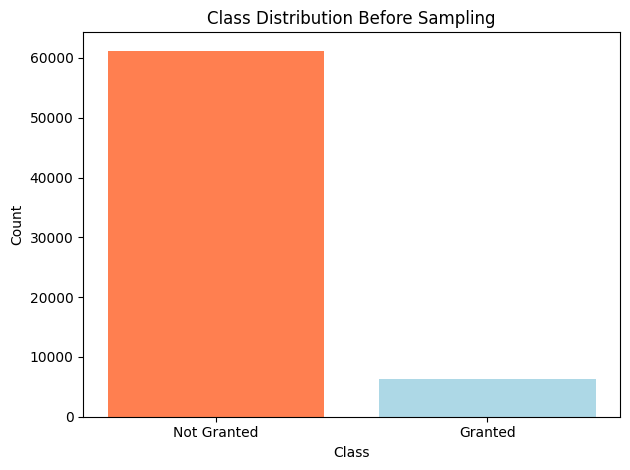

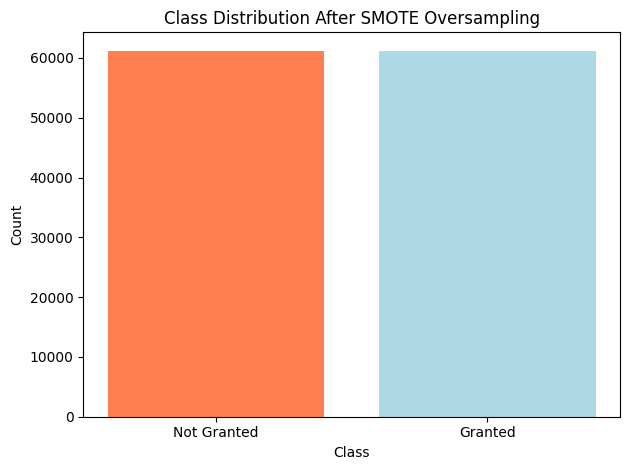

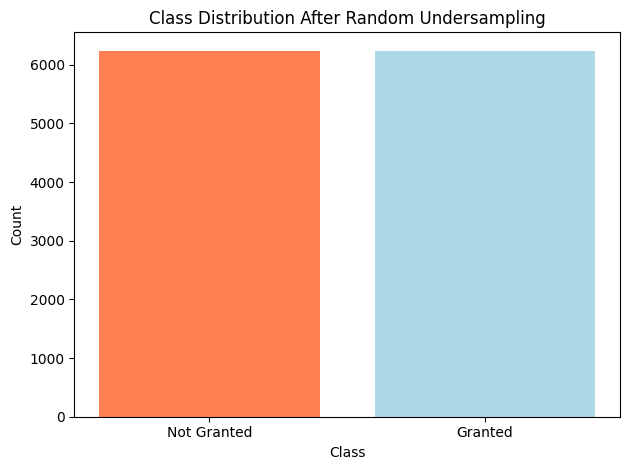

In [ ]:
# Encode categorical features using OneHotEncoder
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Transform the data
X_encoded = preprocessor.fit_transform(X)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_encoded, y)

print("\nClass Distribution After SMOTE Oversampling:")
print(Counter(y_resampled_smote))

# Undersampling with RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_encoded, y)

print("\nClass Distribution After Random Undersampling:")
print(Counter(y_resampled_rus))

# Visualize Class Distribution
def plot_class_distribution(y, title):
    counts = Counter(y)
    plt.bar(counts.keys(), counts.values(), color=['coral', 'lightblue'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels=['Not Granted', 'Granted'])
    plt.tight_layout()
    plt.show()

plot_class_distribution(y, 'Class Distribution Before Sampling')
plot_class_distribution(y_resampled_smote, 'Class Distribution After SMOTE Oversampling')
plot_class_distribution(y_resampled_rus, 'Class Distribution After Random Undersampling')

#### Descriptive Statistics & Data Visualization


In [ ]:
# Descriptive statistics for numerical columns
desc_stats = df_encode.describe()

In [ ]:
desc_stats

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,...,Total Current Balance,Total Revolving Credit Limit,Loan Status,Loan to Funded Ratio,Revolving Credit Utilization,Debt-to-Income Ratio,Years Since Last Payment,Home Ownership (Binary),Interaction: Interest Rate * Loan Amount,Interaction: Revolving Utilization * Total Accounts
count,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,...,6.746300e+04,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.0,67463.000000,67463.000000
mean,16848.902776,15770.599114,14621.799323,11.846258,80541.502522,23.299241,0.327127,0.145754,14.266561,0.081437,...,1.595739e+05,23123.005544,0.092510,1.420882,0.795545,0.232992,1.368524,0.0,199444.352454,984.096748
std,8367.865726,8150.992662,6785.345170,3.718629,45029.120366,8.451824,0.800888,0.473291,6.225060,0.346606,...,1.390332e+05,20916.699999,0.289747,1.179668,1.582962,0.084518,0.832997,0.0,121123.616215,635.902441
min,1014.000000,1014.000000,1114.590204,5.320006,14573.537170,0.675299,0.000000,0.000000,2.000000,0.000000,...,6.170000e+02,1000.000000,0.000000,0.030335,0.000000,0.006753,0.000000,0.0,6042.266525,0.082758
25%,10012.000000,9266.500000,9831.684984,9.297147,51689.843335,16.756416,0.000000,0.000000,10.000000,0.000000,...,5.037900e+04,8155.500000,0.000000,0.623800,0.121485,0.167564,0.673077,0.0,107077.415990,500.251598
50%,16073.000000,13042.000000,12793.682170,11.377696,69335.832680,22.656658,0.000000,0.000000,13.000000,0.000000,...,1.183690e+05,16733.000000,0.000000,1.085045,0.317982,0.226567,1.307692,0.0,177880.699309,890.408609
75%,22106.000000,21793.000000,17807.594120,14.193533,94623.322785,30.048400,0.000000,0.000000,16.000000,0.000000,...,2.283750e+05,32146.500000,0.000000,1.884044,0.809357,0.300484,2.019231,0.0,268068.926980,1343.244666
max,35000.000000,34999.000000,34999.746430,27.182348,406561.536400,39.629862,8.000000,5.000000,37.000000,4.000000,...,1.177412e+06,201169.000000,1.000000,32.425049,58.966197,0.396299,3.096154,0.0,893626.411167,6118.936567


Text(0.5, 1.0, 'Distribution of Loan Amount')

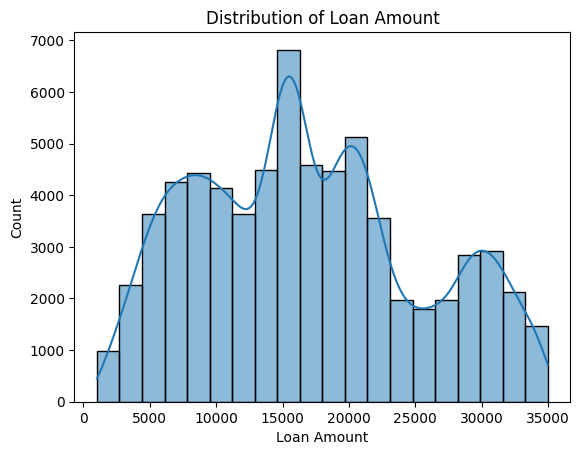

In [ ]:
# Histogram for "Loan Amount"
sns.histplot(df_encode['Loan Amount'], kde=True, bins=20)
plt.title('Distribution of Loan Amount')

Text(0.5, 1.0, 'Distribution of Interest Rate')

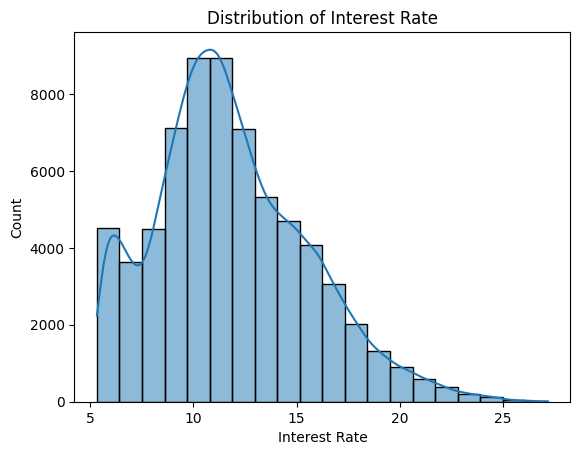

In [ ]:
# Histogram for "Interest Rate"
sns.histplot(df_encode['Interest Rate'], kde=True, bins=20)
plt.title('Distribution of Interest Rate')

In [ ]:
print(df_encode.columns)

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
       'Interest Rate', 'Employment Duration', 'Home Ownership',
       'Verification Status', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Loan to Funded Ratio',
       'Revolving Credit Utilization', 'Debt-to-Income Ratio',
       'Years Since Last Payment', 'Home Ownership (Binary)', 'Term_58',
       'Term_59', 'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F',
       'Grade_G', 'Interaction: Interest Rate * Loan Amount',
       'Interaction: Revolving Utilization *

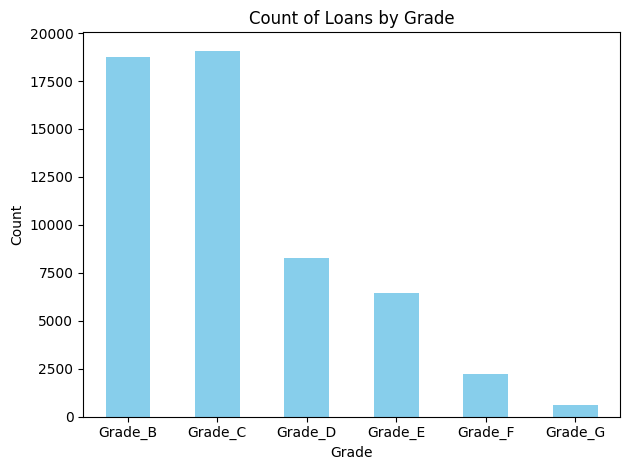

In [ ]:
# Summing up one-hot encoded Grade columns
grade_columns = ['Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F', 'Grade_G']
grade_counts = df_encode[grade_columns].sum()

# Bar plot for grade distribution
grade_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Loans by Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

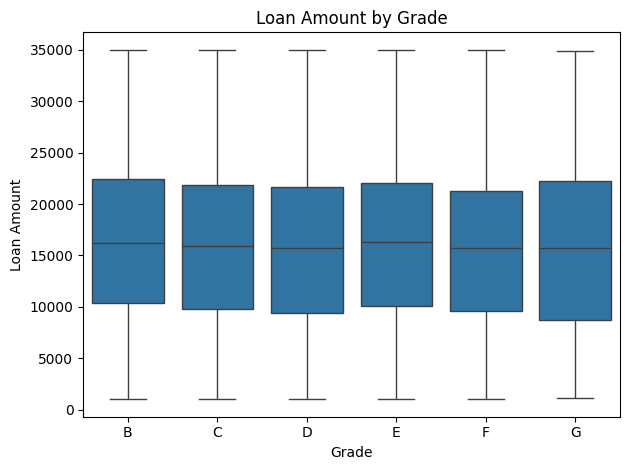

In [ ]:
# Reverse one-hot encoding of Grade columns into a single 'Grade' column
grade_columns = ['Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F', 'Grade_G']
df_encode['Grade'] = df_encode[grade_columns].idxmax(axis=1).str[-1]

# Box plot for "Loan Amount" by "Grade"
sns.boxplot(data=df_encode, x='Grade', y='Loan Amount', order=['B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Loan Amount by Grade')
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.tight_layout()
plt.show()

#### Correlation Analysis

In [ ]:
# Computing the correlation matrix for the cleaned data
correlation_matrix = df_encode.select_dtypes(include=np.number).corr()

In [ ]:
correlation_matrix

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,...,Total Current Balance,Total Revolving Credit Limit,Loan Status,Loan to Funded Ratio,Revolving Credit Utilization,Debt-to-Income Ratio,Years Since Last Payment,Home Ownership (Binary),Interaction: Interest Rate * Loan Amount,Interaction: Revolving Utilization * Total Accounts
Loan Amount,1.000000,-0.000551,0.002831,-0.004888,0.016691,0.007959,-0.000469,0.008962,0.009088,-0.002542,...,-0.008285,0.002289,-0.004473,0.599577,-0.000088,0.007959,-0.002362,NaN,0.817251,0.007703
Funded Amount,-0.000551,1.000000,0.010227,0.002310,-0.003518,0.002347,0.011313,-0.001587,0.005755,0.003750,...,-0.001499,0.006145,0.001364,-0.578167,-0.001435,0.002347,-0.003476,NaN,0.000185,0.009576
Funded Amount Investor,0.002831,0.010227,1.000000,-0.001917,0.001339,0.000112,0.001925,-0.003073,-0.007850,0.005002,...,0.003283,0.005669,-0.000091,-0.008054,-0.005550,0.000112,0.004248,NaN,0.001907,0.000311
Interest Rate,-0.004888,0.002310,-0.001917,1.000000,0.005467,-0.011203,0.004045,0.009172,-0.003250,0.006979,...,-0.002567,0.016651,0.002900,-0.010347,0.003076,-0.011203,-0.012652,NaN,0.511421,0.008319
Home Ownership,0.016691,-0.003518,0.001339,0.005467,1.000000,0.022781,-0.003793,0.005024,0.009080,0.005631,...,0.007117,0.005008,0.003716,0.020363,0.010322,0.022781,-0.004573,NaN,0.017166,0.011388
Debit to Income,0.007959,0.002347,0.000112,-0.011203,0.022781,1.000000,-0.004007,0.002246,0.001100,-0.007813,...,-0.011582,-0.007236,-0.003057,0.002949,-0.001145,1.000000,0.008639,NaN,0.000261,-0.000024
Delinquency - two years,-0.000469,0.011313,0.001925,0.004045,-0.003793,-0.004007,1.000000,0.014679,0.004904,0.006716,...,0.002602,0.009315,0.009990,-0.008096,-0.002078,-0.004007,0.001160,NaN,0.001898,-0.001432
Inquires - six months,0.008962,-0.001587,-0.003073,0.009172,0.005024,0.002246,0.014679,1.000000,-0.002109,0.004087,...,0.001531,0.004678,0.000578,0.005255,-0.000129,0.002246,-0.004453,NaN,0.011443,0.008884
Open Account,0.009088,0.005755,-0.007850,-0.003250,0.009080,0.001100,0.004904,-0.002109,1.000000,-0.010762,...,-0.007470,0.003096,-0.007073,0.003385,0.010380,0.001100,-0.013415,NaN,0.005778,0.007964
Public Record,-0.002542,0.003750,0.005002,0.006979,0.005631,-0.007813,0.006716,0.004087,-0.010762,1.000000,...,0.003935,0.012046,0.010590,-0.008528,-0.004897,-0.007813,0.004281,NaN,0.001031,-0.000273


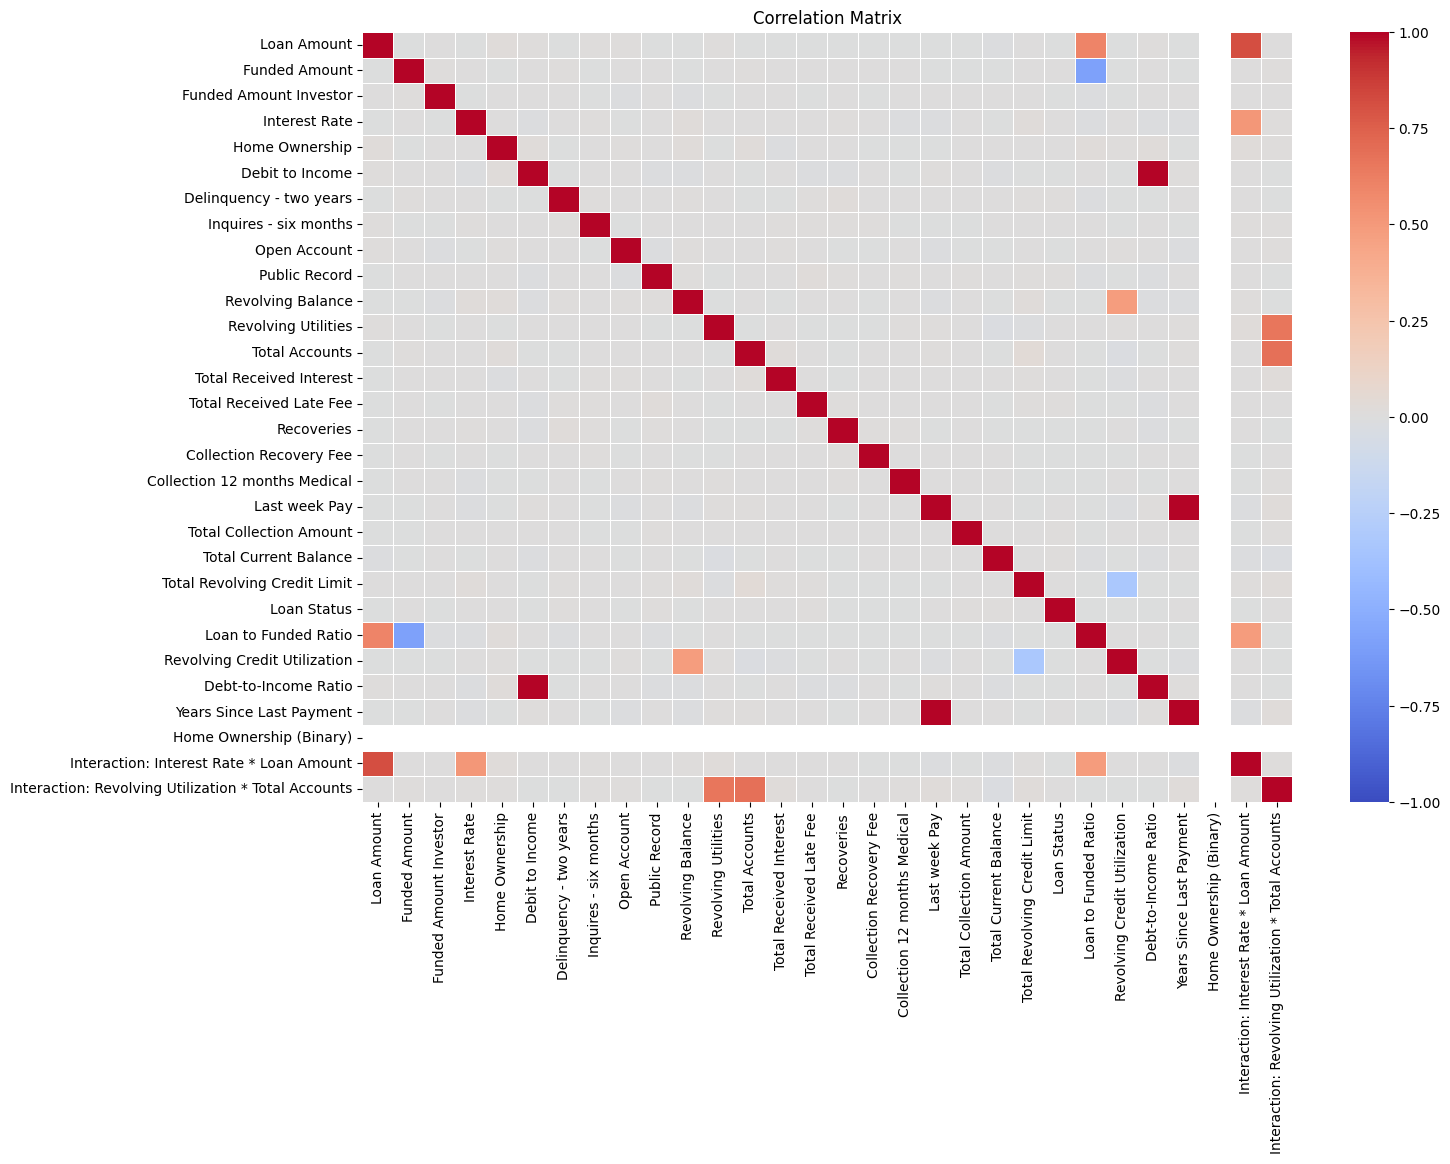

In [ ]:
# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=False, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### 2. Data Preparation

In [ ]:
data_types = df_encode.dtypes

In [ ]:
data_types

,0
Loan Amount,int64
Funded Amount,int64
Funded Amount Investor,float64
Interest Rate,float64
Employment Duration,object
Home Ownership,float64
Verification Status,object
Debit to Income,float64
Delinquency - two years,int64
Inquires - six months,int64


In [ ]:
# Extracting columns that are of type 'object' to check for potential inconsistencies
object_columns = data_types[data_types == 'object'].index

In [ ]:
object_columns

Index(['Employment Duration', 'Verification Status', 'Initial List Status',
       'Application Type', 'Grade'],
      dtype='object')

In [ ]:
# Displaying unique values for each object column to identify any inconsistencies
unique_values_in_object_columns = {col: df_encode[col].unique() for col in object_columns}

In [ ]:
unique_values_in_object_columns

{'Employment Duration': array(['MORTGAGE', 'RENT', 'OWN'], dtype=object),
 'Verification Status': array(['Not Verified', 'Source Verified', 'Verified'], dtype=object),
 'Initial List Status': array(['w', 'f'], dtype=object),
 'Application Type': array(['INDIVIDUAL', 'JOINT'], dtype=object),
 'Grade': array(['B', 'C', 'F', 'G', 'E', 'D'], dtype=object)}

In [ ]:
# Update the list of columns based on the dataset
categorical_columns = ['Employment Duration', 'Verification Status',
                       'Initial List Status', 'Application Type']
df = pd.get_dummies(df_encode, columns=categorical_columns)

In [ ]:
df

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,...,Employment Duration_MORTGAGE,Employment Duration_OWN,Employment Duration_RENT,Verification Status_Not Verified,Verification Status_Source Verified,Verification Status_Verified,Initial List Status_f,Initial List Status_w,Application Type_INDIVIDUAL,Application Type_JOINT
0,10000,32236,12329.36286,11.135007,176346.62670,16.284758,1,0,13,0,...,True,False,False,True,False,False,False,True,True,False
1,3609,11940,12191.99692,12.237563,39833.92100,15.412409,0,0,12,0,...,False,False,True,False,True,False,True,False,True,False
2,28276,9311,21603.22455,12.545884,91506.69105,28.137619,0,0,14,0,...,True,False,False,False,True,False,False,True,True,False
3,11170,6954,17877.15585,16.731201,108286.57590,18.043730,1,0,7,0,...,True,False,False,False,True,False,False,True,True,False
4,16890,13226,13539.92667,15.008300,44234.82545,17.209886,1,3,13,1,...,True,False,False,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,13601,6848,13175.28583,9.408858,83961.15003,28.105127,1,0,13,0,...,True,False,False,False,False,True,False,True,True,False
67459,8323,11046,15637.46301,9.972104,65491.12817,17.694279,0,0,12,0,...,False,False,True,False,True,False,False,True,True,False
67460,15897,32921,12329.45775,19.650943,34813.96985,10.295774,0,0,7,1,...,True,False,False,False,False,True,False,True,True,False
67461,16567,4975,21353.68465,13.169095,96938.83564,7.614624,0,0,14,0,...,False,True,False,True,False,False,True,False,True,False


In [ ]:
# Count the number of occurrences of each unique value in the 'Loan Status' column
loan_status_count = df['Loan Status'].value_counts()

In [ ]:
loan_status_count

,count
Loan Status,
0,61222
1,6241


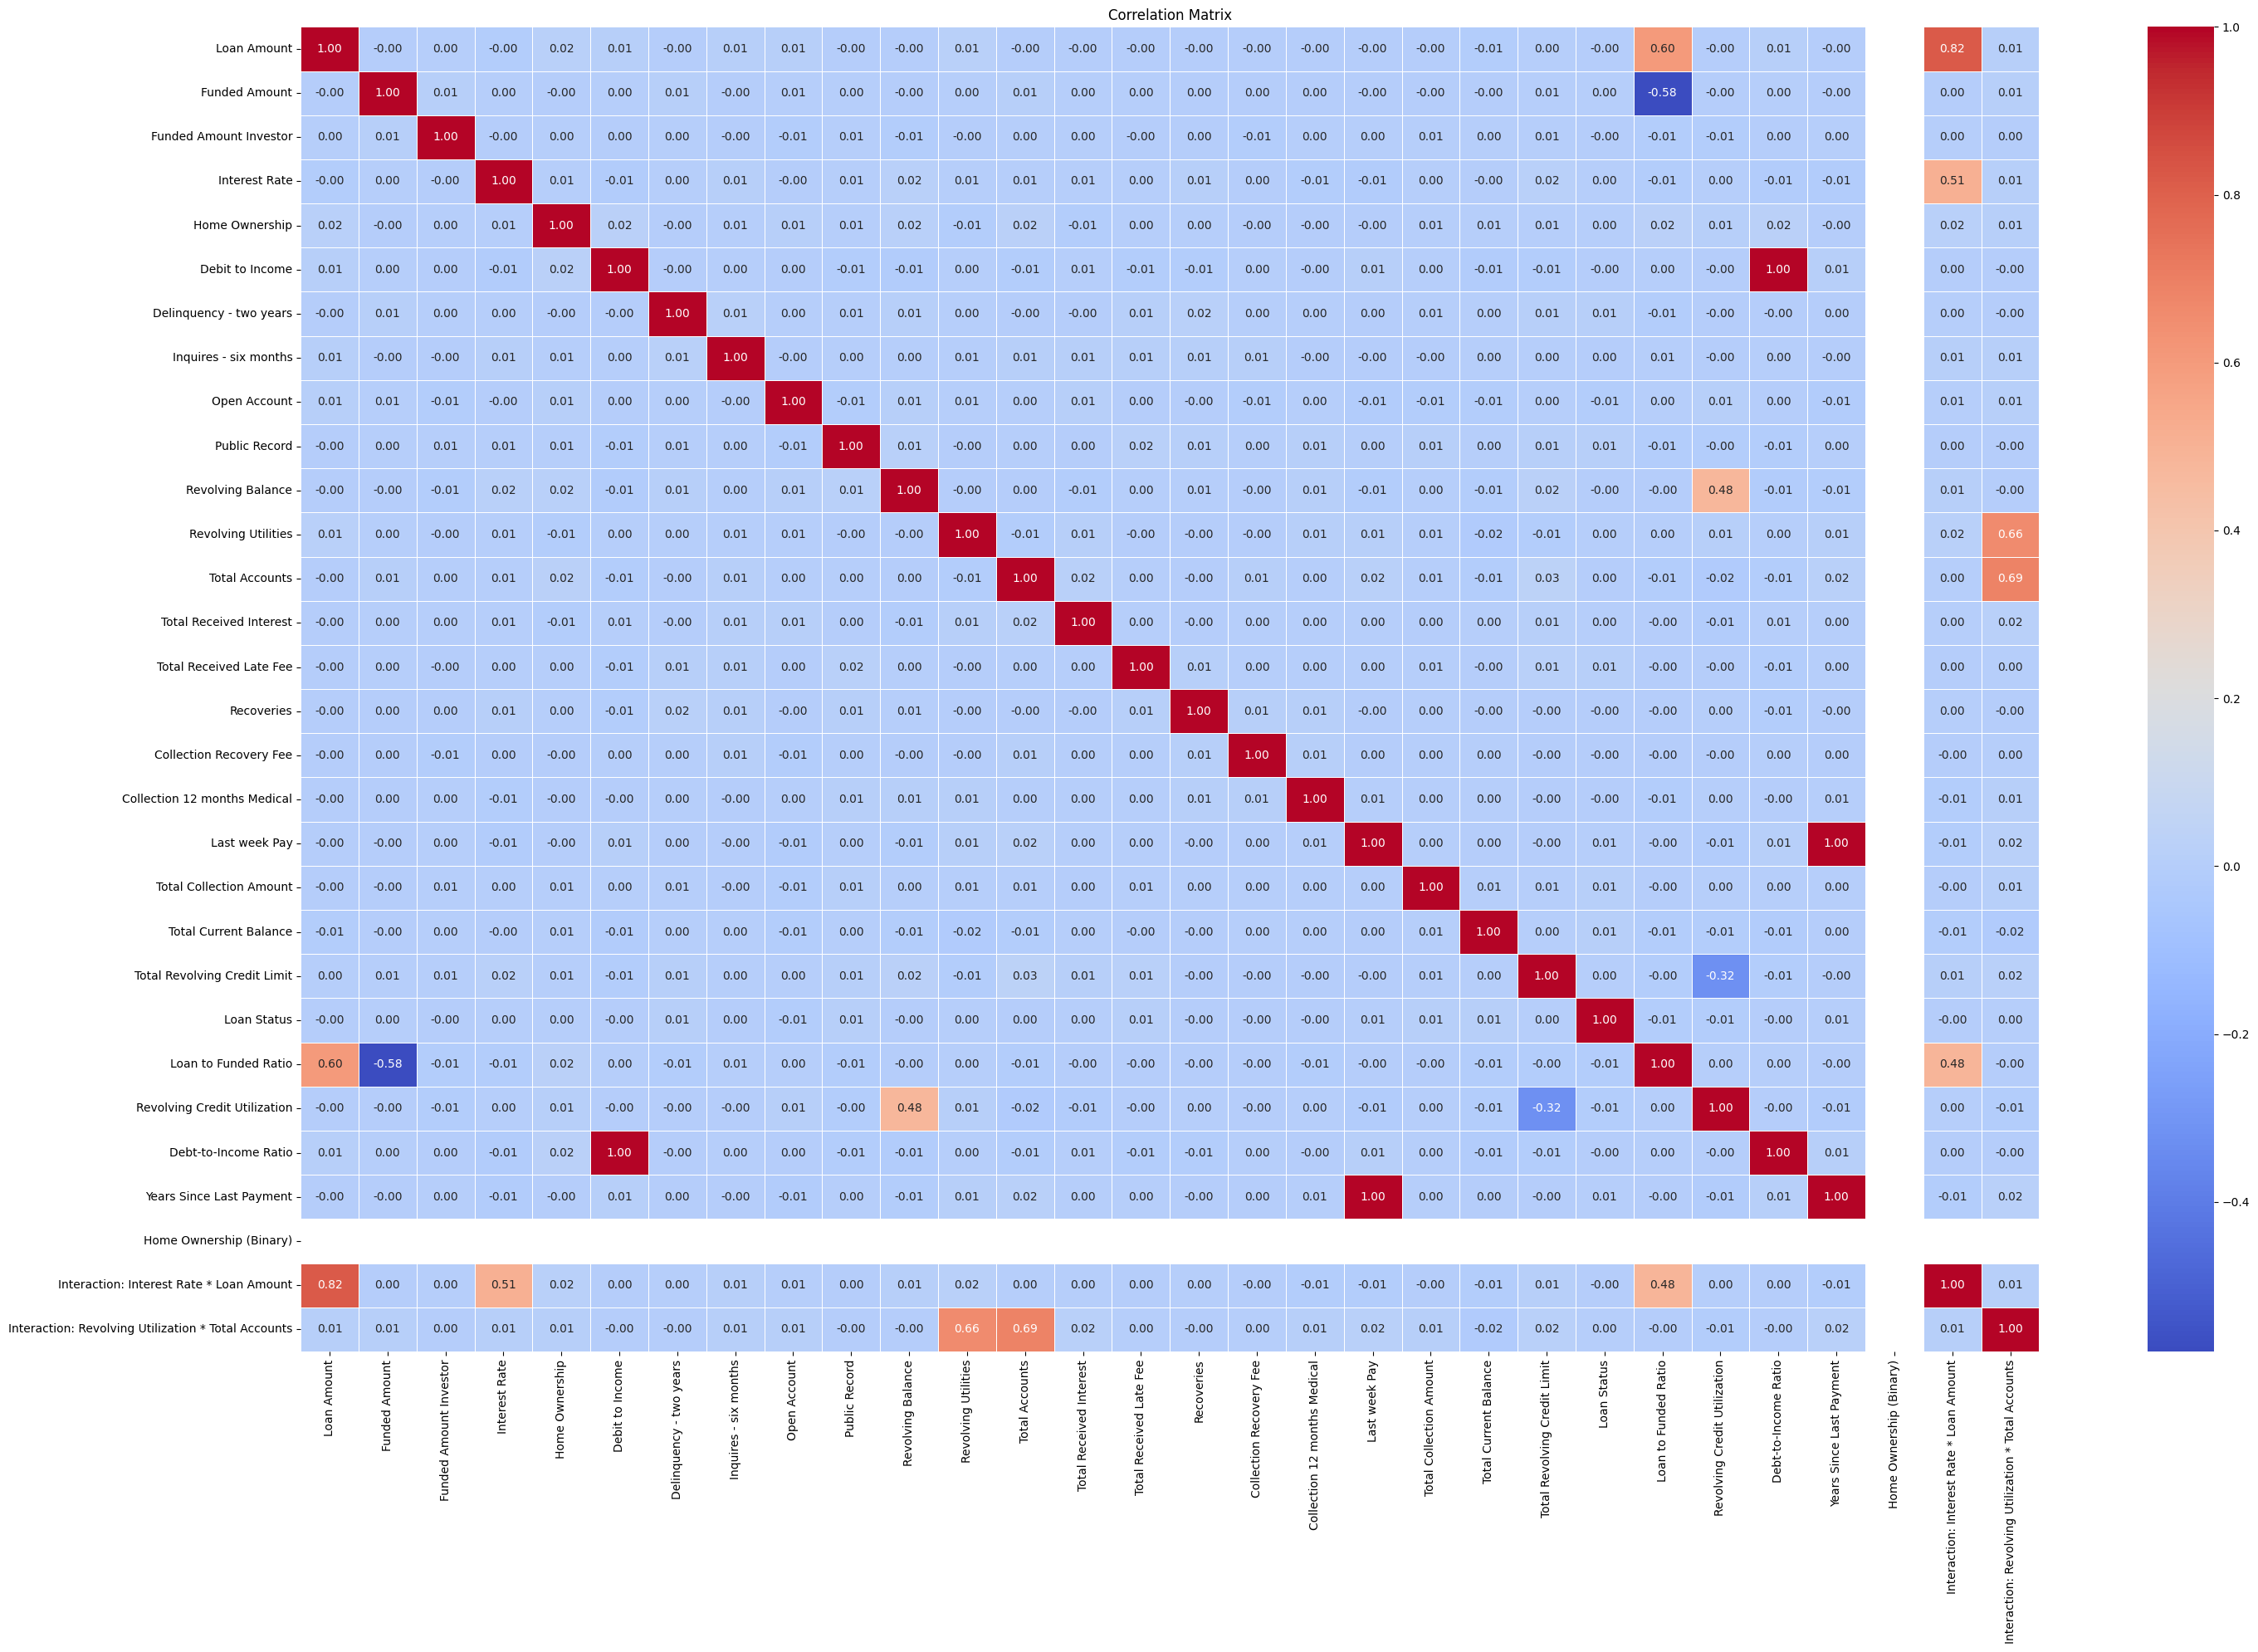

In [ ]:
# Select numeric columns only
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(30, 20), dpi=100)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
       'Interest Rate', 'Home Ownership', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Total Received Interest', 'Total Received Late Fee',
       'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Loan to Funded Ratio',
       'Revolving Credit Utilization', 'Debt-to-Income Ratio',
       'Years Since Last Payment', 'Home Ownership (Binary)', 'Term_58',
       'Term_59', 'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F',
       'Grade_G', 'Interaction: Interest Rate * Loan Amount',
       'Interaction: Revolving Utilization * Total Accounts', 'Grade',
       'Employment Duration_MORTGAGE', 'Employment Duration_OWN',
       'Em

In [ ]:
# Hypothesis Testing
categorical_features = [
    'Term_58', 'Term_59',
    'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F', 'Grade_G',
    'Verification Status_Not Verified', 'Verification Status_Source Verified', 'Verification Status_Verified',
    'Home Ownership (Binary)',
    'Application Type_INDIVIDUAL', 'Application Type_JOINT'
]
target = 'Loan Status'

for feature in categorical_features:
    if feature in df.columns:
        # Create a contingency table
        contingency_table = pd.crosstab(df[feature], df[target])

        # Perform Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Output Results
        print(f"Chi-Square Test for {feature} and {target}:")
        print(f"Chi-Square Statistic: {chi2:.4f}, P-Value: {p:.4f}")
        print(f"Degrees of Freedom: {dof}")
        print("Significant Relationship" if p < 0.05 else "No Significant Relationship")
        print("-" * 60)
    else:
        print(f"Feature '{feature}' does not exist in the DataFrame.")


Chi-Square Test for Term_58 and Loan Status:
Chi-Square Statistic: 38.5523, P-Value: 0.0000
Degrees of Freedom: 1
Significant Relationship
------------------------------------------------------------
Chi-Square Test for Term_59 and Loan Status:
Chi-Square Statistic: 31.1299, P-Value: 0.0000
Degrees of Freedom: 1
Significant Relationship
------------------------------------------------------------
Chi-Square Test for Grade_B and Loan Status:
Chi-Square Statistic: 8.5075, P-Value: 0.0035
Degrees of Freedom: 1
Significant Relationship
------------------------------------------------------------
Chi-Square Test for Grade_C and Loan Status:
Chi-Square Statistic: 0.5860, P-Value: 0.4440
Degrees of Freedom: 1
No Significant Relationship
------------------------------------------------------------
Chi-Square Test for Grade_D and Loan Status:
Chi-Square Statistic: 1.6266, P-Value: 0.2022
Degrees of Freedom: 1
No Significant Relationship
----------------------------------------------------------

In [ ]:
# T-Test for Numerical Features
numerical_features = ['Loan Amount', 'Interest Rate', 'Debit to Income']

for feature in numerical_features:
    group1 = df[df[target] == 0][feature]
    group2 = df[df[target] == 1][feature]
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    print(f"T-Test for {feature} by {target}:")
    print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
    print("Significant Difference" if p_value < 0.05 else "No Significant Difference")
    print("-" * 60)

T-Test for Loan Amount by Loan Status:
T-Statistic: 1.1492, P-Value: 0.2505
No Significant Difference
------------------------------------------------------------
T-Test for Interest Rate by Loan Status:
T-Statistic: -0.7406, P-Value: 0.4590
No Significant Difference
------------------------------------------------------------
T-Test for Debit to Income by Loan Status:
T-Statistic: 0.8001, P-Value: 0.4237
No Significant Difference
------------------------------------------------------------


In [ ]:
# ANOVA Test for Categorical and Numerical Feature Relationships
for feature in numerical_features:
    groups = [df[df['Grade'] == category][feature] for category in df['Grade'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA Test for {feature} by Grade:")
    print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4f}")
    print("Significant Difference" if p_value < 0.05 else "No Significant Difference")
    print("-" * 60)

ANOVA Test for Loan Amount by Grade:
F-Statistic: 12.8199, P-Value: 0.0000
Significant Difference
------------------------------------------------------------
ANOVA Test for Interest Rate by Grade:
F-Statistic: 2.6393, P-Value: 0.0216
Significant Difference
------------------------------------------------------------
ANOVA Test for Debit to Income by Grade:
F-Statistic: 6.7068, P-Value: 0.0000
Significant Difference
------------------------------------------------------------


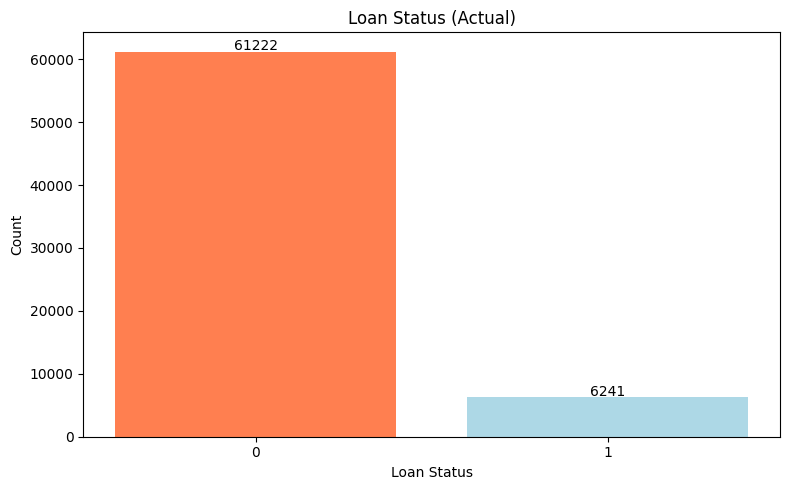

In [ ]:
# Plotting
plt.figure(figsize=(8,5), dpi=100)
bars = plt.bar(loan_status_count.index.astype(str), loan_status_count.values, color=['coral', 'lightblue'])

# Title and labels
plt.title('Loan Status (Actual)')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Adding counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 900, round(yval, 2), va='center', ha='center')

# Show the plot
plt.tight_layout()
plt.show()


In the dataset, 61,222 people did not receive a loan (LoanStatus=0), and 6,241 people received a loan (LoanStatus=1). This indicates a somewhat imbalanced dataset, with a significantly larger number of instances in one class (no loan granted) compared to the other (loan granted). This is an important aspect to consider during the model development stage as it might influence the model's ability to learn the minority class.

### 3. Modelling

In [ ]:
# Sanitize column names to remove special characters
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Encode categorical columns
categorical_columns = ['Grade', 'Employment Duration', 'Verification Status',
                       'Home Ownership', 'Application Type', 'Initial List Status']

label_encoders = {}
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Ensure all columns are numeric
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# ML Models
models = {
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
    "Extra Trees Classifier": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

# Train-test split for 70:30 ratio
train_ratio, test_ratio = 0.7, 0.3
print(f"\nProcessing train-test split: {train_ratio * 100}% train, {test_ratio * 100}% test")
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)

# Dictionary to store results
results = []

# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Predict labels
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

        # Append metrics to results
        results.append([
            model_name, train_ratio, test_ratio, accuracy, precision, recall, f1, roc_auc
        ])
        print(f"Completed {model_name} successfully.")
    except Exception as e:
        print(f"Error with {model_name}: {e}")

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(
    results,
    columns=['Model', 'Train Ratio', 'Test Ratio', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
)

# Display results
print("\nFinal Results for 70:30 Split:")
print(results_df)


Processing train-test split: 70.0% train, 30.0% test
Training Balanced Random Forest...
Completed Balanced Random Forest successfully.
Training Random Forest Classifier...
Completed Random Forest Classifier successfully.
Training HistGradientBoosting...
Completed HistGradientBoosting successfully.
Training Gradient Boosting...
Completed Gradient Boosting successfully.
Training Logistic Regression...
Completed Logistic Regression successfully.
Training Extra Trees Classifier...
Completed Extra Trees Classifier successfully.
Training XGBoost...
Completed XGBoost successfully.
Training LightGBM...
[LightGBM] [Info] Number of positive: 4388, number of negative: 42836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5588
[LightGBM] [Info] Number of data points in the train set: 47224, nu

In [ ]:
results_df

,Model,Train Ratio,Test Ratio,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Balanced Random Forest,0.7,0.3,0.539305,0.095594,0.476525,0.159243,0.517680
1,Random Forest Classifier,0.7,0.3,0.908444,0.000000,0.000000,0.000000,0.511748
2,HistGradientBoosting,0.7,0.3,0.908444,0.000000,0.000000,0.000000,0.532165
3,Gradient Boosting,0.7,0.3,0.908296,0.000000,0.000000,0.000000,0.529089
4,Logistic Regression,0.7,0.3,0.497900,0.095669,0.530491,0.162104,0.509727
5,Extra Trees Classifier,0.7,0.3,0.908444,0.000000,0.000000,0.000000,0.509418
6,XGBoost,0.7,0.3,0.907061,0.088235,0.001619,0.003180,0.515296
7,LightGBM,0.7,0.3,0.908444,0.000000,0.000000,0.000000,0.520241
8,CatBoost,0.7,0.3,0.908395,0.000000,0.000000,0.000000,0.524337


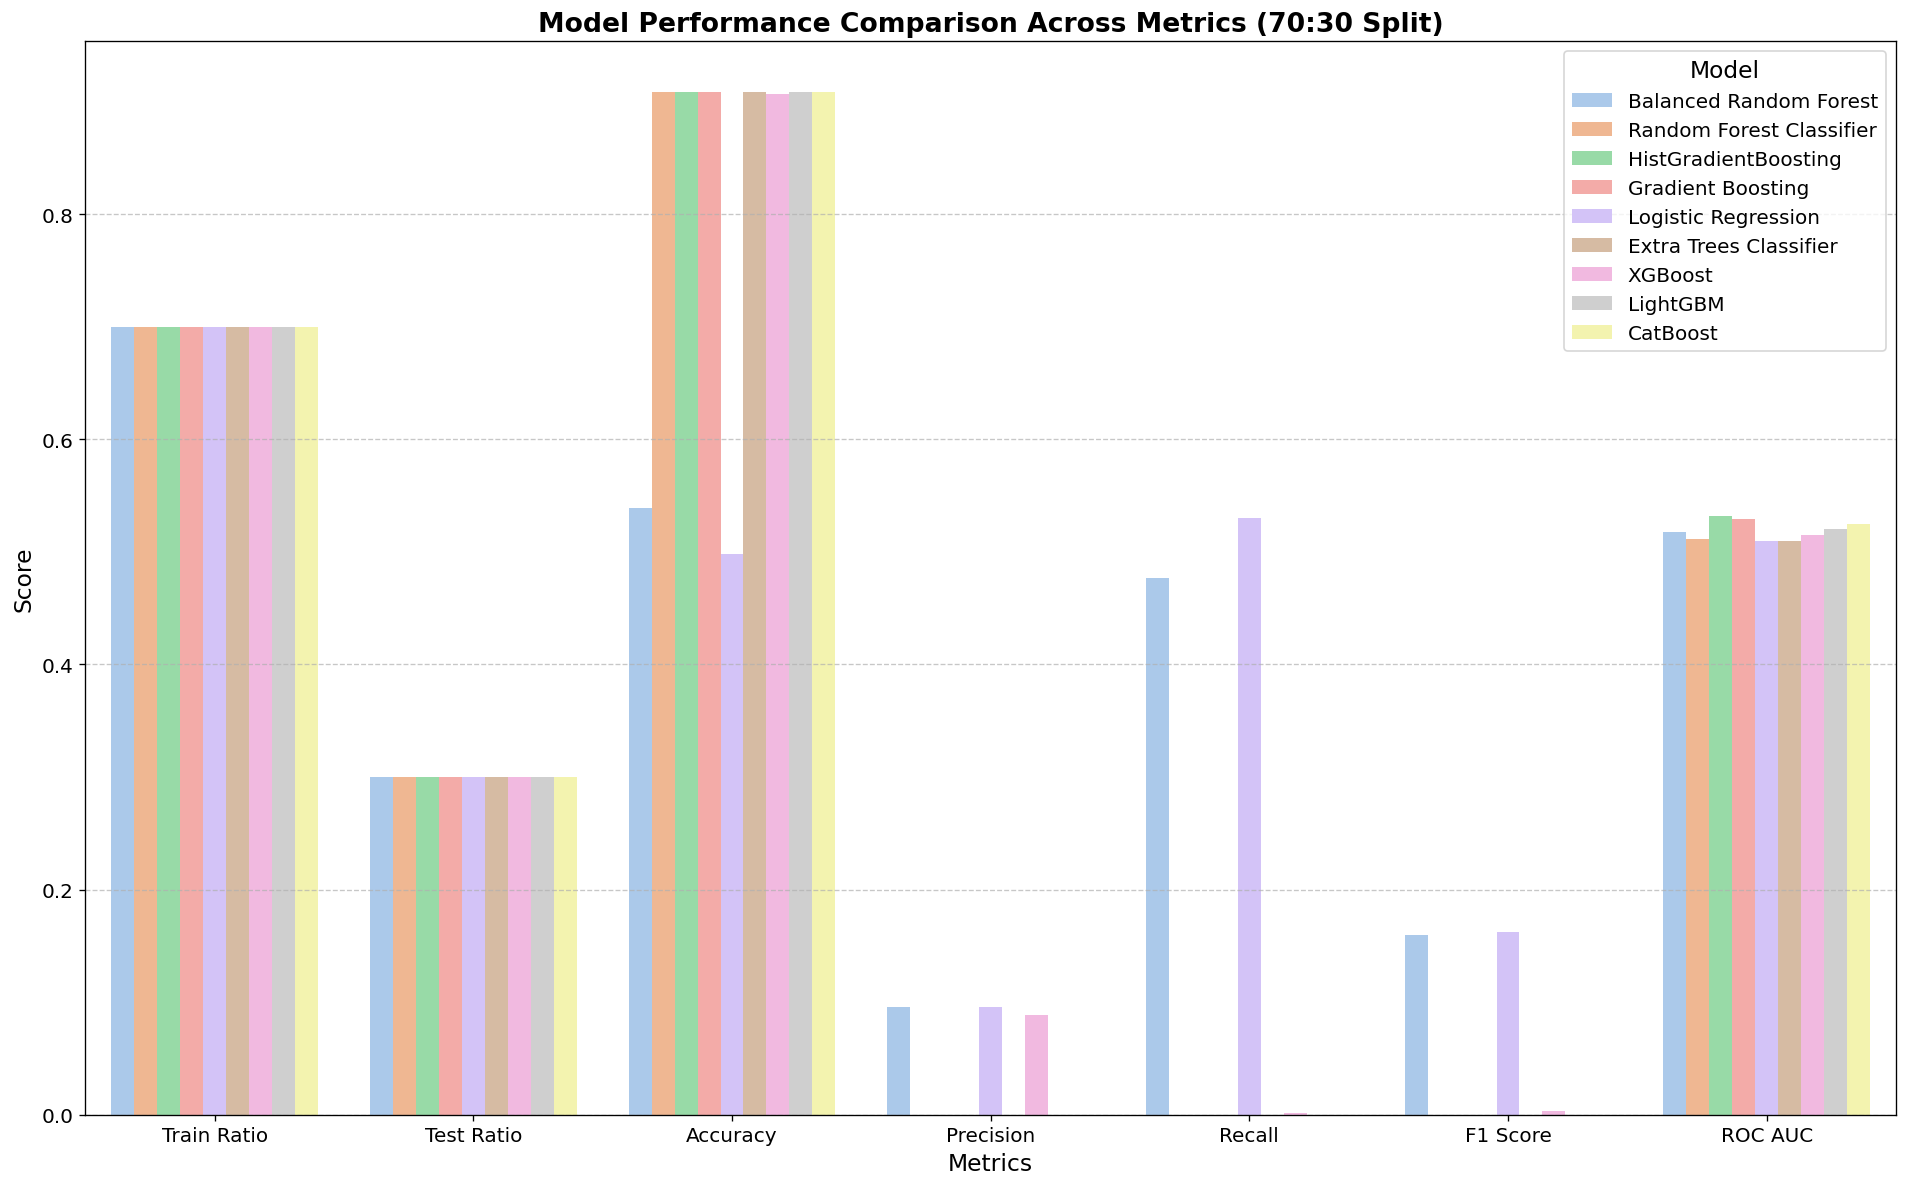

In [ ]:
# Reshape the results DataFrame for plotting
metrics_df = results_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

# Enhanced bar plot
plt.figure(figsize=(16, 10), dpi=120)

# Use a color palette for better aesthetics
palette = sns.color_palette("pastel")

sns.barplot(
    data=metrics_df,
    x='Metric', y='Score', hue='Model', ci=None, palette=palette
)

# Add title, labels, and legend
plt.title('Model Performance Comparison Across Metrics (70:30 Split)', fontsize=16, weight='bold')
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Rotate x-axis ticks for clarity
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend position and font size
plt.legend(title='Model', title_fontsize=14, fontsize=12, loc='upper right', frameon=True)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tighten layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Display the best model per metric
print("Best Models by Metric:")
metrics_to_check = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
for metric in metrics_to_check:
    best_row = results_df.loc[results_df[metric] == results_df[metric].max()]
    print(f"\nBest Model for {metric}:")
    print(best_row[['Model', metric]])

Best Models by Metric:

Best Model for Accuracy:
                      Model  Accuracy
1  Random Forest Classifier  0.908444
2      HistGradientBoosting  0.908444
5    Extra Trees Classifier  0.908444
7                  LightGBM  0.908444

Best Model for Precision:
                 Model  Precision
4  Logistic Regression   0.095669

Best Model for Recall:
                 Model    Recall
4  Logistic Regression  0.530491

Best Model for F1 Score:
                 Model  F1 Score
4  Logistic Regression  0.162104

Best Model for ROC AUC:
                  Model   ROC AUC
2  HistGradientBoosting  0.532165


In [ ]:
# Expanded Model Metrics Evaluation
expanded_results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    expanded_results.append([model_name, accuracy, precision, recall, f1, roc_auc, mcc, kappa])
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, "
          f"ROC AUC: {roc_auc}, MCC: {mcc:.4f}, Kappa: {kappa:.4f}")
    print("-" * 60)

# Convert expanded results to DataFrame
metrics_columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 'Kappa']
expanded_results_df = pd.DataFrame(expanded_results, columns=metrics_columns)

Model: Balanced Random Forest
Accuracy: 0.5393, Precision: 0.0956, Recall: 0.4765, F1 Score: 0.1592, ROC AUC: 0.517680132628659, MCC: 0.0128, Kappa: 0.0079
------------------------------------------------------------
Model: Random Forest Classifier
Accuracy: 0.9084, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.5117482012669603, MCC: 0.0000, Kappa: 0.0000
------------------------------------------------------------
Model: HistGradientBoosting
Accuracy: 0.9084, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.5321650533158075, MCC: 0.0000, Kappa: 0.0000
------------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.9083, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.5290894213193607, MCC: -0.0039, Kappa: -0.0003
------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.4979, Precision: 0.0957, Recall: 0.5305, F1 Score: 0.1621, ROC AUC: 0.5097273031305818, MCC: 

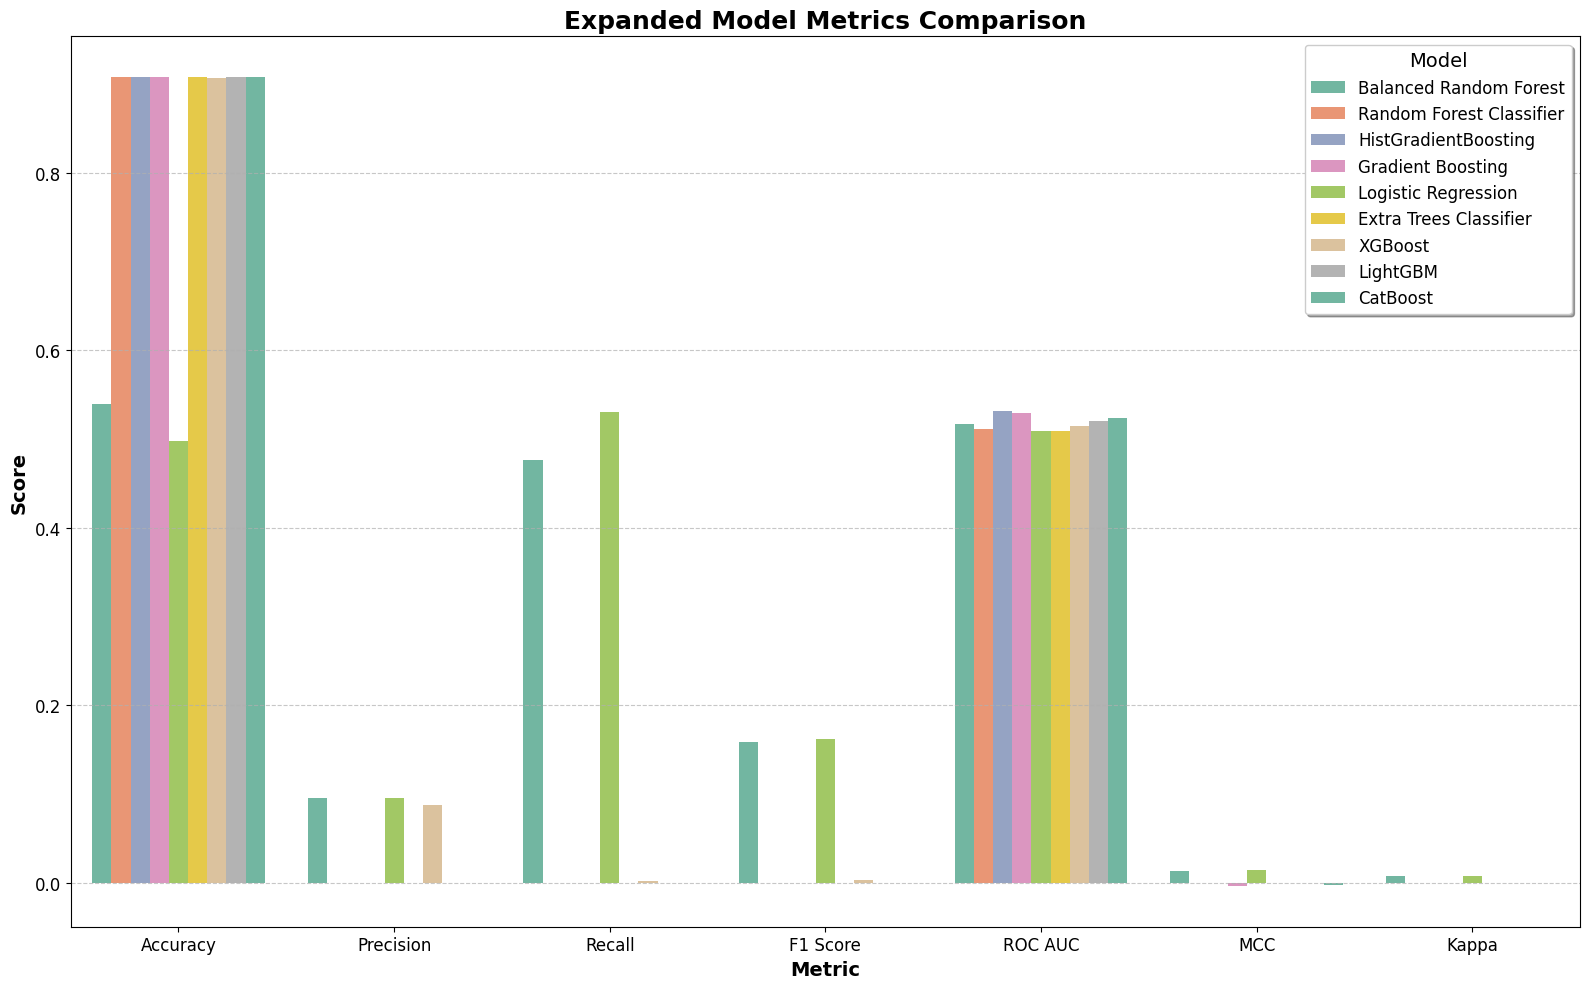

In [ ]:
plt.figure(figsize=(16, 10), dpi=100)

# Use a visually appealing color palette
palette = sns.color_palette("Set2")

sns.barplot(
    data=expanded_results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
    x='Metric',
    y='Score',
    hue='Model',
    ci=None,
    palette=palette
)

# Add title and labels with improved formatting
plt.title('Expanded Model Metrics Comparison', fontsize=18, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
plt.ylabel('Score', fontsize=14, weight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add legend with customized position and appearance
plt.legend(title='Model', title_fontsize=14, fontsize=12, loc='upper right', frameon=True, shadow=True)

# Add gridlines for easier comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to prevent clipping
plt.tight_layout()

# Show the enhanced plot
plt.show()

In [ ]:
y

,Loan_Status
0,0
1,0
2,0
3,0
4,0
...,...
67458,1
67459,0
67460,0
67461,0


Best Model: Extra Trees Classifier


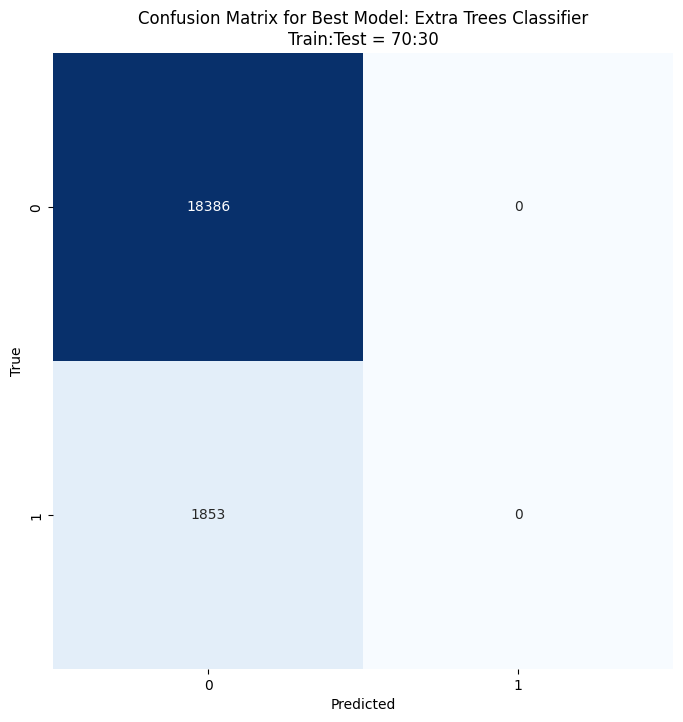

In [ ]:
# Calculate average accuracies for each model
average_accuracies = results_df.groupby('Model')['Accuracy'].mean()

# Select the best model based on the highest average accuracy
best_model_name = average_accuracies.idxmax()
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

# Define the best train-test split for confusion matrix
best_train_ratio = 0.7
best_test_ratio = 0.3

# Split the data with the best ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=best_train_ratio, random_state=42)

# Train the best model on the selected train-test split
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 8), dpi=100)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False)
plt.title(f'Confusion Matrix for Best Model: {best_model_name}\nTrain:Test = {int(best_train_ratio * 100)}:{int(best_test_ratio * 100)}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
best_model

ExtraTreesClassifier(random_state=42)

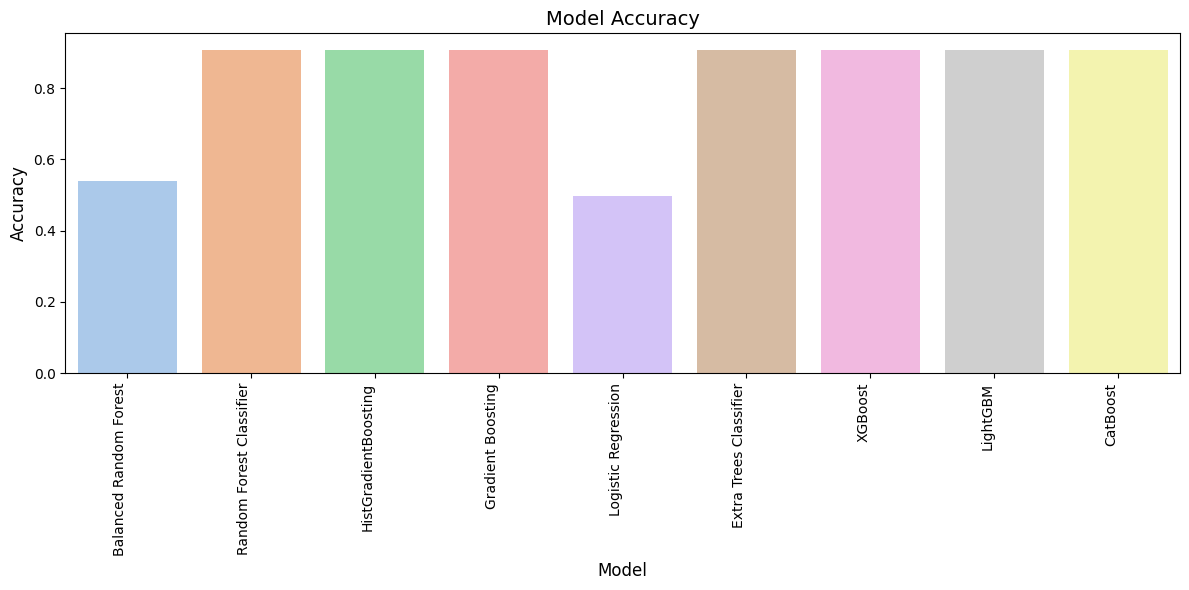

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="pastel")
plt.title("Model Accuracy", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=10)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Reshape the results DataFrame for heatmap visualization
metrics_df = results_df.melt(id_vars=["Model"],
                             value_vars=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
                             var_name="Metric",
                             value_name="Score")

# Check the reshaped DataFrame
print(metrics_df.head())

                      Model    Metric     Score
0    Balanced Random Forest  Accuracy  0.539305
1  Random Forest Classifier  Accuracy  0.908444
2      HistGradientBoosting  Accuracy  0.908444
3         Gradient Boosting  Accuracy  0.908296
4       Logistic Regression  Accuracy  0.497900


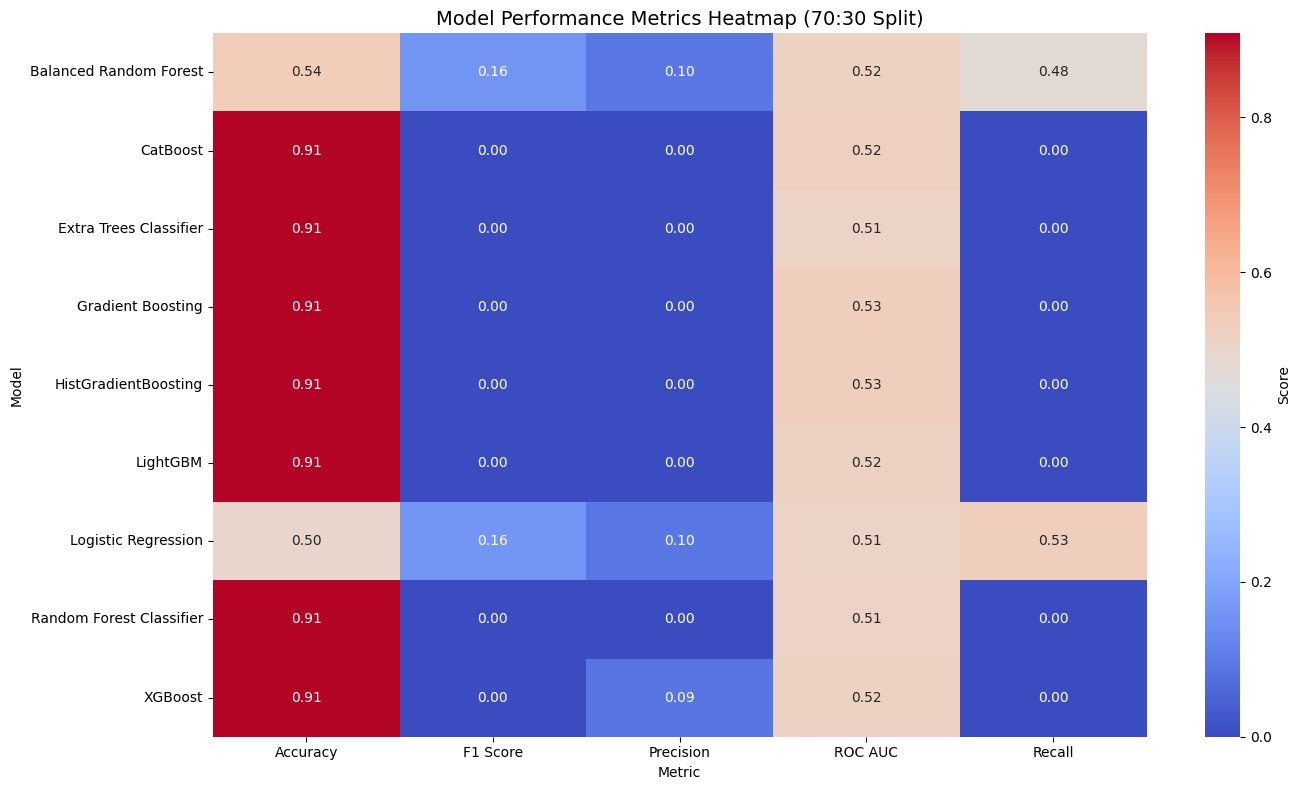

In [ ]:
# Reshape the DataFrame using pivot
heatmap_data = metrics_df.pivot(index="Model", columns="Metric", values="Score")

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Score'})
plt.title("Model Performance Metrics Heatmap (70:30 Split)", fontsize=14)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


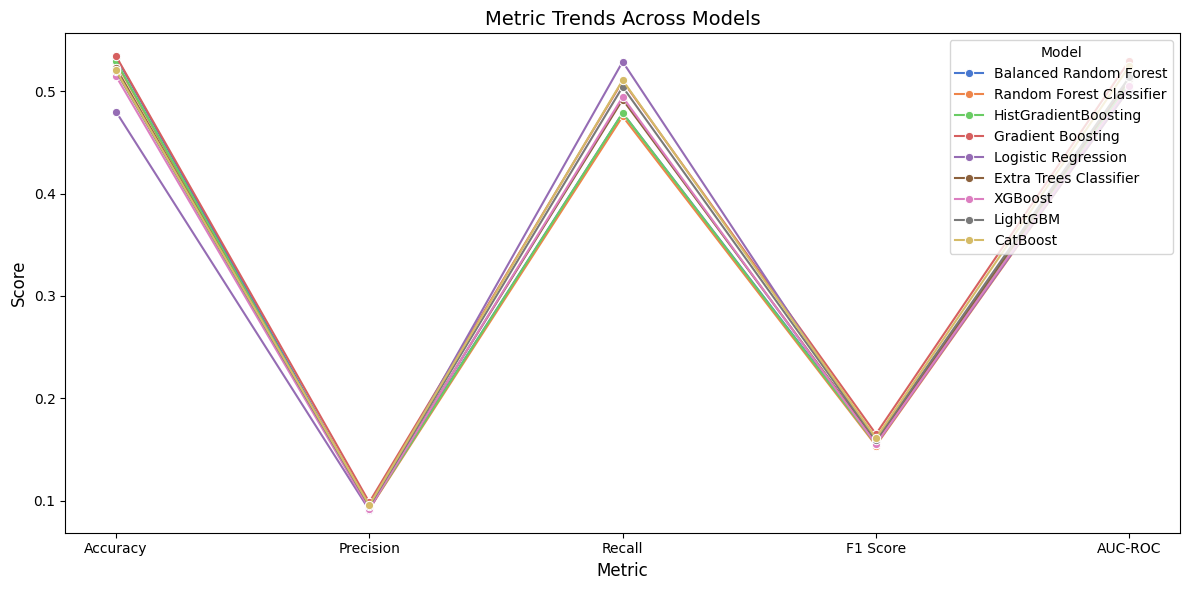

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x="Metric", y="Score", hue="Model", marker="o", palette="muted")
plt.title("Metric Trends Across Models", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Model", fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()

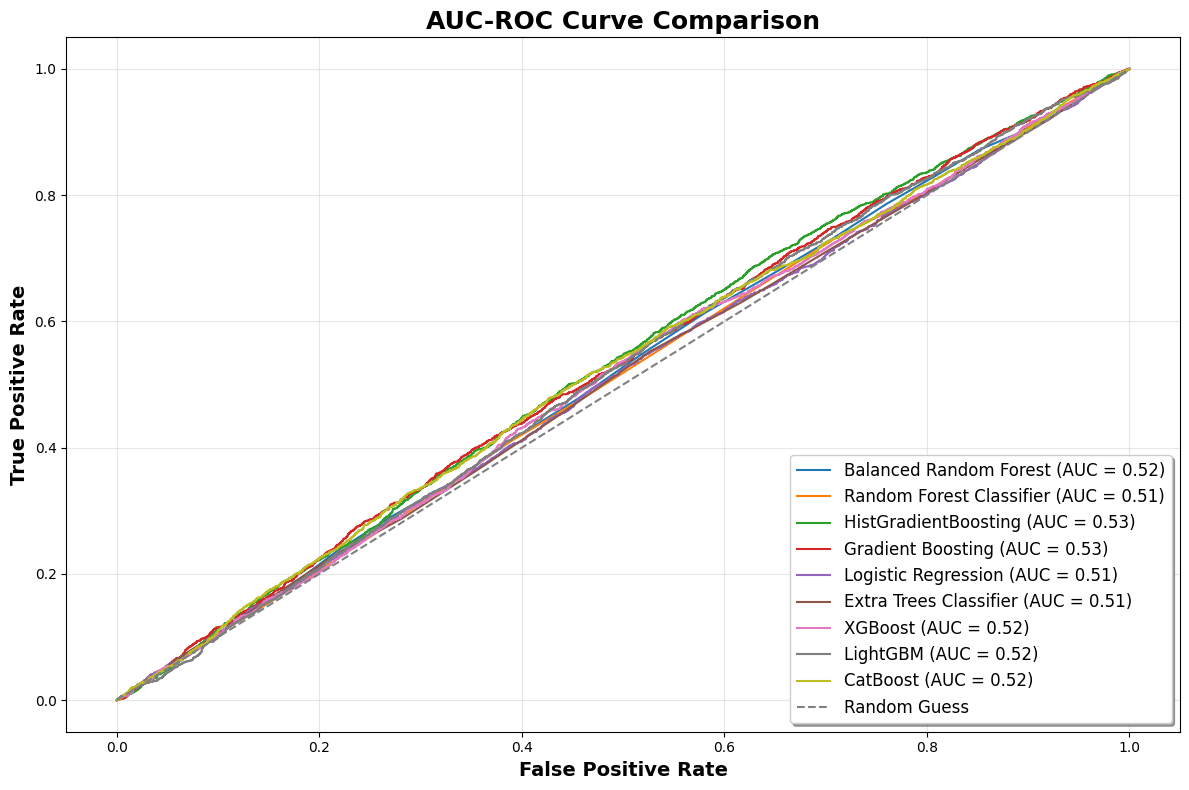

In [ ]:
# Initialize a plot for ROC curves
plt.figure(figsize=(12, 8), dpi=100)

# Loop through each model and calculate the ROC curve
for model_name, model in models.items():
    try:
        # Get predicted probabilities
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute the ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    except AttributeError:
        # Skip models that do not support probability predictions
        print(f"{model_name} does not support predict_proba, skipping...")

# Plot diagonal for reference
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

# Add title, labels, legend, and grid
plt.title('AUC-ROC Curve Comparison', fontsize=18, weight='bold')
plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()